# Resource Allocation for Demand Variability

This question relies on the demand predictions done in B1.

In [53]:
#pip install pulp

In [54]:
# Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, PULP_CBC_CMD
import seaborn as sns

In [55]:
## Load Data from B1 ##

df = pd.read_csv("output.csv")
scaler = StandardScaler()

# Standardize the variables to be used for deriving the response variable (demand score)
df[["Max_wait_time_std", "Total_units_std"]] = scaler.fit_transform(df[["Max_wait_time", "Total_units"]])
df.drop(columns=["Max_wait_time","Total_units"], inplace=True)

df["Demand_Score"] = (df["Max_wait_time_std"] + df["Total_units_std"]) / 2
df.drop(columns=["Max_wait_time_std","Total_units_std","Year_Month"], inplace=True)

# Final Dataset
df

,Park_Fatalities_Previous_Year,Fraction of Not Rainy,Fraction of Rainy,Drought Count,Flooding Count,Freeze Count,Severe Storm Count,Tropical Cyclone Count,Wildfire Count,Winter Storm Count,...,Attraction_Spinning Coaster,Attraction_Spiral Slide,Attraction_Superman Ride,Attraction_Swing Ride,Attraction_Tilt-A-Whirl,Attraction_Top Spin,Attraction_Vertical Drop,Attraction_Water Ride,Attraction_Zipline,Demand_Score
0,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.267251
1,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-0.137697
2,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1.375315
3,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,-0.635457
4,2,0.935484,0.064516,0.0,0.0,0.0,0.166667,0.083333,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0.002851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2073,3,0.032258,0.967742,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0.949974
2074,3,0.032258,0.967742,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,...,0,0,0,0,0,1,0,0,0,-0.725837
2075,3,0.032258,0.967742,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,...,0,0,0,0,0,0,1,0,0,-0.141929
2076,3,0.032258,0.967742,0.0,0.0,0.0,0.166667,0.166667,0.0,0.0,...,0,0,0,0,0,0,0,1,0,-0.268936


### Demand Prediction (from B1)

From B1, we have concluded that Random Forest Regressor will be our final predictive model for demand prediction.

In [56]:
# Features and target variable
X = df.drop(columns=["Demand_Score"])  # Features
y = df["Demand_Score"]  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifying split sizes
print(f"Training data size: {X_train.shape[0]} samples")
print(f"Test data size: {X_test.shape[0]} samples")

# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)  # different from B1 code

y_pred = rf_model.predict(X_test) # different from B1 code

Training data size: 1662 samples
Test data size: 416 samples


## Optimization

**(Current) Optimization Problem: Minimize the total number of staff required in a theme park**

I have made several tentative assumptions for now, for simplicity:
- Synthetic demand prediction data has been generated
- At least 1 staff member working, capped at 15 staff members.
- Staff costs have been excluded

Other considerations that need to be made:
- Decide final optimization problem (minimize or maximise what?)
- Staff cost model: will all staff be paid the same through the months & days? (peak period bonus etc.)
- Are staff required during park closing hours? (define park closing hours)

Data required:
- predicted demand for each month
- average predicted surge in attendance during all special events
- average peak periods in a day, surge in each hour

c:\Users\joann\anaconda3\Lib\site-packages\pulp\pulp.py:1423: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


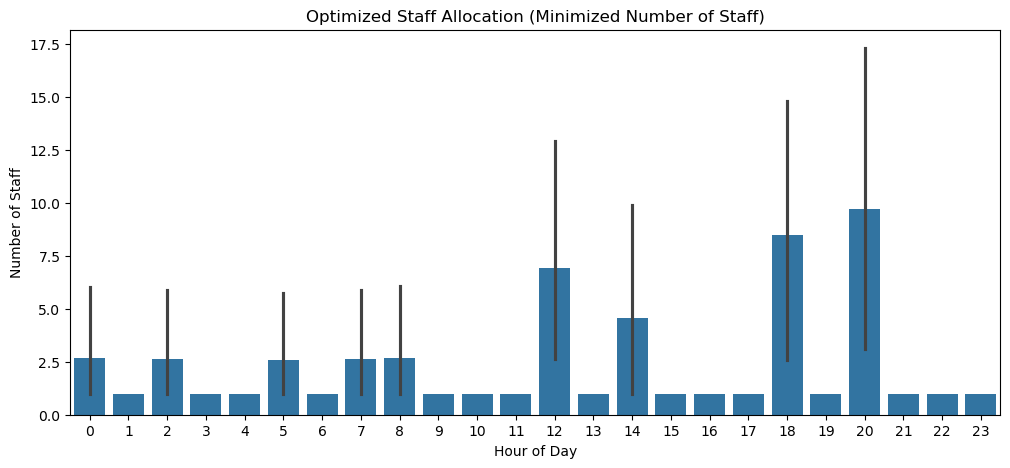

In [57]:
### USE SYNTHETIC DATA FOR NOW ###

# Sample Data: Predicted Demand for Each Hour, Month, and Special Events
np.random.seed(42)
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
time_periods = list(range(24))  # for 24 hours

# Generate synthetic demand with seasonality and special events
data = []
for month in months:
    for hour in time_periods:
        base_demand = np.random.randint(50, 300)  # Base demand
        event_multiplier = np.random.choice([1, 1.5], p=[0.8, 0.2])  # 20% chance of event surge
        peak_multiplier = 1.5 if hour in [12, 18, 20] else 1  # Higher demand at peak hours
        demand = base_demand * event_multiplier * peak_multiplier
        special_event = "Yes" if event_multiplier > 1 else "No"
        data.append([month, hour, special_event, demand])

df = pd.DataFrame(data, columns=['Month', 'Hour', 'Special_Event', 'Predicted_Demand'])

# Decision variables for staffing per month and hour
'''
At least 1 staff member,  capped at 15 staff members.
Number of staff must be an integer.
Staff decision for every (month, hour) combination is created.
'''
staff = {(month, t): LpVariable(f"staff_{month}_{t}", lowBound=1, upBound=15, cat='Integer')
         for month in months for t in time_periods}

# Define the optimization model
model = LpProblem("Optimizing Staff Allocation", LpMinimize)

# Objective function: Minimize total number of staff
model += lpSum(staff[month, t] for month in months for t in time_periods), "Total Staff"

# Constraints: Ensure sufficient staff for predicted demand
for month, hour in staff.keys():
    demand = df[(df['Month'] == month) & (df['Hour'] == hour)]['Predicted_Demand'].values[0]
    model += staff[month, hour] >= (demand / 20), f"Demand_Constraint_{month}_{hour}"

# Solve the optimization problem
model.solve(PULP_CBC_CMD(msg=False))

# Extract optimized staffing
optimized_staffing = {(month, t): staff[month, t].varValue for month in months for t in time_periods}

# Convert results into DataFrame for visualization
staff_schedule = pd.DataFrame([(month, hour, v) for (month, hour), v in optimized_staffing.items()],
                              columns=['Month', 'Hour', 'Staff'])
staff_schedule.set_index(['Month', 'Hour'], inplace=True)

# Visualization
plt.figure(figsize=(12,5))
sns.barplot(data=staff_schedule.reset_index(), x="Hour", y="Staff")
plt.title("Optimized Staff Allocation (Minimized Number of Staff)")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Staff")
plt.show()